In [1]:
%matplotlib inline
# %matplotlib notebook

import time
import math

import numpy as np
from scipy import signal
from scipy.io import wavfile

from scipy.linalg import toeplitz
from scipy.linalg import solve
from scipy.spatial import Voronoi, voronoi_plot_2d

import matplotlib.pyplot as plt
from matplotlib import gridspec
from  matplotlib import patches
from matplotlib.pyplot import axvline, axhline
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

import IPython.display as ipd

#### Funciones útiles

In [2]:
def wavread(filename):
    """ read wave file using scipy.io.wavfile
    """
    # read wave file 
    fs, y = wavfile.read(filename)
    
    # convert scipy data array to float and normalize amplitude
    if y.dtype == np.int16:
        y = y.astype(float)
        y /= 32767
    
    return fs, y


def plot_espectrograma_stft(X_stft, fs):
    # max frequency index
    ind_fmax = int(X_stft.shape[0]/2)+1
    # frequency values (Hz)
    stft_freqs = omega_stft[:ind_fmax]*fs/(2*np.pi)
    # time values of the stft
    stft_time = samps_stft/fs

    plt.figure(figsize=(12,8))
    ax1 = plt.subplot(2, 1, 1)
    plt.pcolormesh(stft_time, stft_freqs, 20*np.log10(np.abs(X_stft[:ind_fmax, :])), cmap='jet')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Frecuencia [Hz]')
    

def plot_audio_signal(fs, y, leg=None):
    # time corresponding to the audio signal
    time = np.arange(0, y.size)/fs

    # plot audio signal
    #plt.figure(figsize=(12, 3))
    # ax1 = plt.subplot(2, 1, 1)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.plot(time, y, label=leg)


def plot_espectrograma(fs, y, nperseg_=512, noverlap_=64, nfft_=12000):
    max_f_bin = 300

    # plot audio signal
    #plt.figure(figsize=(12, 4))
    # ax1 = plt.subplot(2, 1, 1)
    f, t, S = signal.spectrogram(y, fs, nperseg=nperseg_, noverlap=noverlap_, nfft=nfft_, mode='psd', window='hann')
    plt.pcolormesh(t, f, 20*np.log10(S), cmap='jet')
    plt.ylabel('Frequencia [Hz]')
    plt.xlabel('Tiempo [s]')
    
    print(np.min(f), np.max(f), np.min(t), np.max(t))

    # ax2 = plt.subplot(2, 1, 2)
    # S, f, t, imageAxis = plt.specgram(y, Fs=fs, NFFT=1024, noverlap=256, mode='psd', cmap='jet')
    # plt.ylabel('Frecuencia (Hz)')
    # plt.xlabel('Tiempo (s)')

## <center> EJERCICIO 1 

### Parte 1
    
#### Parte 1.1 - Graficar cepstrum complejo


$$ \frac{P}{n} \beta^n \sum_{k=1}^{\infty} \delta[n-kP] $$
    
Graficar utilizando los valores $\beta = 0.99$ y $P = 80$

c:\users\santiago\audio_env\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


Text(0.5, 0, 'Quefrency (muestras)')

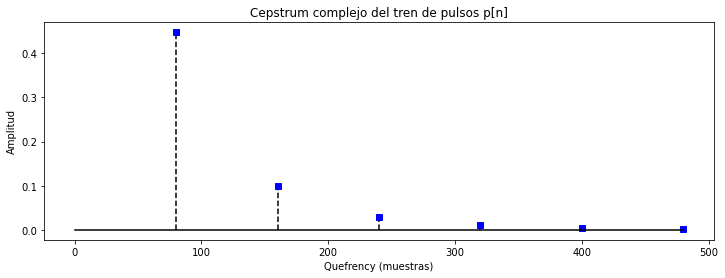

In [3]:
# number of samples (note this is not the period)
N = 512
# period in samples (the N value of the equation)
P = 80
# atenuation factor
beta = 0.99

# create the signal in time
muestras = np.arange(7) * P
p = np.zeros(7)

pulsos = P / muestras * beta**muestras
pulsos[0] = None


plt.figure(figsize=(12,4))
ax = plt.subplot(1,1,1)
plt.stem(muestras,pulsos,  markerfmt='sb', linefmt='--k', basefmt='k',use_line_collection=True)
plt.title('Cepstrum complejo del tren de pulsos p[n]')
plt.ylabel('Amplitud')
plt.xlabel('Quefrency (muestras)')
# plt.savefig('.\Imagenes\EJ1\cepstrum_Pn.png', dpi=300)

#### Parte 1.2 - Graficar cepstrum complejo

$$H(z) = \frac{(1-bz)(1-b^*z)}{(1-cz^{-1})(1-c^*z^{-1})},\;\;\;\textrm{con }|b|,|c|<1$$

Si realizamos el cálculo analítico del cepstrum complejo usando la transformada $\mathcal{Z}$, obtenemos

$$\hat{h}[n]=\frac{2}{n}|b|^{-n}\cos(n\theta_b)u[-n+1] + \frac{2}{n}|c|^n\cos(n\theta_c)u[n-1], \quad \textrm{con} \;\; b=|b|e^{j\theta_b},\;\;c=|c|e^{j\theta_c}.$$

In [4]:
def generar_cepstrum_h(puntos_x=512, mag_b=0.97, phi_b=0.88*np.pi, mag_c=0.97, phi_c=0.12*np.pi):
    
    if puntos_x % 2 == 0:
        ind_ini = int(-puntos_x/2) +1
        ind_fin = int(puntos_x/2)
        ind_cero = ind_fin-1
    else:
        ind_ini = int(-np.floor(puntos_x/2))
        ind_fin = int(np.floor(puntos_x/2))
        ind_cero = ind_fin
        
    n = np.arange(ind_ini,ind_fin+1)
    ind_uno = ind_cero + 1
    hat_h = np.zeros(puntos_x)
    hat_h[:ind_uno+1] = 2*(mag_b**-n[:ind_uno+1])*np.cos(n[:ind_uno+1]*phi_b)/n[:ind_uno+1]
    hat_h[ind_uno:] = 2*(mag_c**n[ind_uno:])*np.cos(n[ind_uno:]*phi_c)/n[ind_uno:]
    
    return n, hat_h, ind_cero
    

In [5]:
n, hat_h_analitico, ind_cero = generar_cepstrum_h(puntos_x=512)

c:\users\santiago\audio_env\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


Text(0.5, 0, 'Quefrency (muestras)')

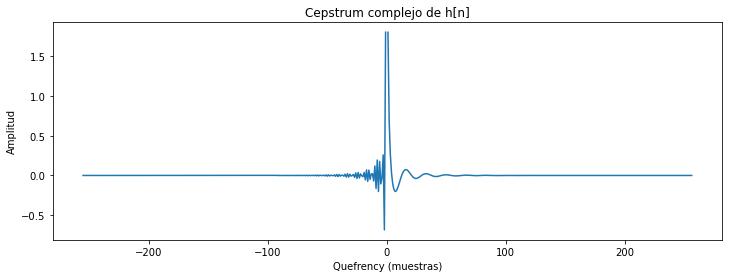

In [6]:
plt.figure(figsize=(12,4))
plt.plot(n,hat_h_analitico)
plt.title('Cepstrum complejo de h[n]')
plt.ylabel('Amplitud')
plt.xlabel('Quefrency (muestras)')

# plt.savefig('.\Imagenes\EJ1\cepstrum_hat_h.png', dpi=300)

#### Parte 1.3

Calcular el cepstrum complejo de $s[n] = h[n] * p[n]$

Text(0.5, 0, 'Quefrency (muestras)')

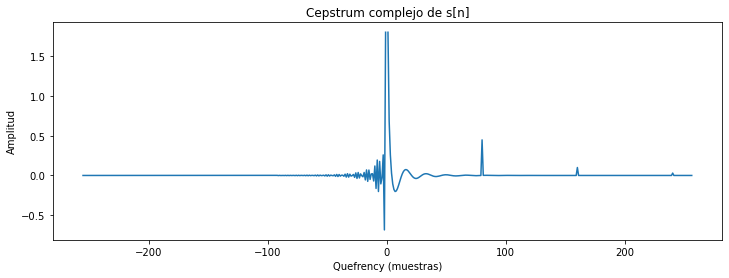

In [7]:
## Cepstrum complejo de s[n] = h[n] conv p[n]

hat_s_analitico = hat_h_analitico.copy()
pulsos[0] = 0
hat_s_analitico[ind_cero:][muestras[:4]] += pulsos[:4]

plt.figure(figsize=(12,4))
plt.plot(n,hat_s_analitico)
plt.title('Cepstrum complejo de s[n]')
plt.ylabel('Amplitud')
plt.xlabel('Quefrency (muestras)')

# plt.savefig('.\Imagenes\EJ1\cepstrum_hat_s.png', dpi=300)

#### Parte 1.4

Calcular el cepstrum complejo de las señales $p[n]$ y $h[n]$ a partir de la DFT

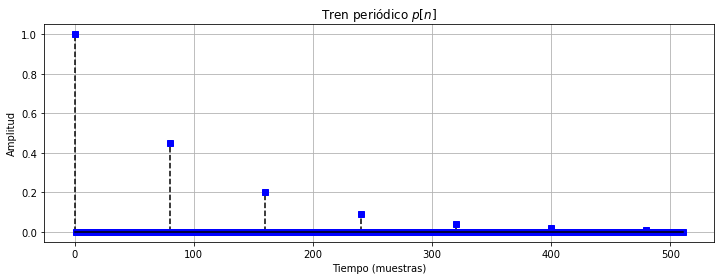

In [8]:
## tren de pulsos p[n]

# number of samples (note this is not the period)
N = 512
# period in samples (the N value of the equation)
T = 80
# atenuation factor
beta = 0.99

# create the signal in time
pn = np.zeros(N)
k = np.arange(1, np.floor((N-1)/T)+1)
kP = k * T
kP = kP.astype(int)
pn[kP] = beta**kP
pn[0] = 1

# plot periodic train
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1, 1, 1)
ax1.stem(pn, markerfmt='sb', linefmt='--k', basefmt='k',use_line_collection=True)
ax1.set_title('Tren periódico $p[n]$')
ax1.set_ylabel('Amplitud')
ax1.set_xlabel('Tiempo (muestras)')
ax1.grid()

# plt.savefig('.\Imagenes\EJ1\pn_time.png', dpi=300)

In [9]:
## Calcular cepstrum complejo de p[n]

Pn = np.fft.fft(pn,N)
# Pn = np.fft.fftshift(Pn)
mag_Pn = np.abs(Pn)
phase_Pn = np.angle(Pn)
phase_Pn_unw = np.unwrap(phase_Pn)

# eliminar componente lineal de fase

# indice de la fase evaulada en pi
ind_pi = int(np.floor((N+1)/2))

# se calcula el factor de fase lineal r
r = round(phase_Pn_unw[ind_pi]/np.pi)

# se calcula el componente de fase lineal
ph_lin_component = r * np.pi * np.arange(N) / ind_pi

# se resta el componente de fase lineal al la fase desdoblada
phase_Pn_unw2 = phase_Pn_unw - ph_lin_component; 

# check that phase at 0 and pi frequency is 0
assert phase_Pn_unw2[0] == 0, "Phase value at zero is not 0"
assert phase_Pn_unw2[ind_pi] == 0, "Phase value at pi is not 0"

In [10]:
# se calcula el logaritmo de la transformada con su fase desdoblada y simetrica

log_Pn = np.log(mag_Pn) + 1j*phase_Pn_unw2

hat_pn = np.real(np.fft.ifft(log_Pn))

Text(0.5, 0, 'Quefrency (muestras)')

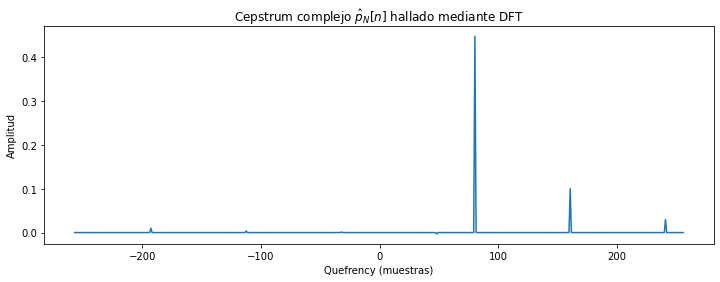

In [11]:
plt.figure(figsize=(12,4))
q = np.linspace(-N/2-1, N/2, N)
plt.plot(q, np.fft.fftshift(hat_pn))
plt.title('Cepstrum complejo $\hat{p}_N[n]$ hallado mediante DFT')
plt.ylabel('Amplitud')
plt.xlabel('Quefrency (muestras)')

# plt.savefig('.\Imagenes\EJ1\hat_pn_dft.png', dpi=300)

In [12]:
## Calcular el cepstrum complejo de h[n]

# magnitude and phase of the zero
mz = 0.97
phiz = 0.88 * np.pi
# magnitude and phase of the pole
mp = 0.97
phip = 0.12 * np.pi

# coefficients of the zero and pole
b = mz * np.exp(1j * phiz)
c = mp * np.exp(1j * phip)

# numerator and denominator coefficients
B = np.array([mz**2, -2*mz*np.cos(phiz), 1])
A = np.array([1, -2*mp*np.cos(phip), mp**2])

# get zero, pole and gain from transfer function
z, p, k = signal.tf2zpk(B, A)

In [13]:
# number of DFT values
N = 512
# compute the transfer function
w, H = signal.freqz(B, A, worN=N, whole=True)

# magnitude 
magH = np.abs(H)
# phase
phaseH = np.angle(H)
# phase unwraped
phaseH_unw1 = np.unwrap(phaseH)

# === elimination of the linear phase component

# index of the phase value at pi
ind_pi = int(np.floor((N+1)/2))

# compute the linear phase factor
r = round(phaseH_unw1[ind_pi]/np.pi)

# compute the linear phase component
ph_lin_component = r * np.pi * np.arange(N) / ind_pi

# substract the linear phase component
phaseH_unw2 = phaseH_unw1 - ph_lin_component; 

# check that phase at 0 and pi frequency is 0
assert phaseH_unw2[0] == 0, "Phase value at zero is not 0"
assert phaseH_unw2[ind_pi] == 0, "Phase value at pi is not 0"

In [14]:
# compute the complex logarithm (using magH and phaseH)
logH = np.log(magH) + 1j* phaseH_unw2

# IDFT
hat_h = np.real(np.fft.ifft(logH))

(-100.0, 100.0)

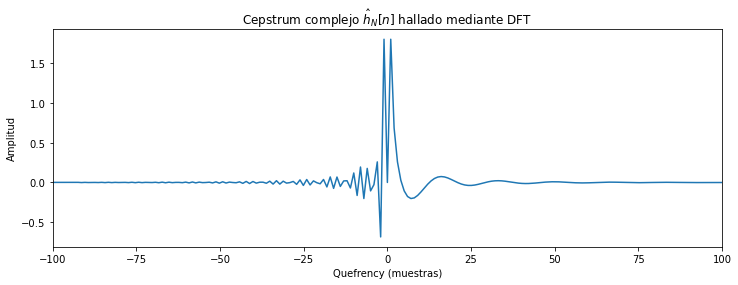

In [15]:
plt.figure(figsize=(12,4))
plt.plot(q, np.fft.fftshift(hat_h))
plt.title('Cepstrum complejo $\hat{h}_N[n]$ hallado mediante DFT')
plt.ylabel('Amplitud')
plt.xlabel('Quefrency (muestras)')
plt.xlim([-100,100])

# plt.savefig('.\Imagenes\EJ1\hat_h_dft.png', dpi=300)

#### Calcular $h[n]$ a partir de $\hat{s}[n]$ 

Text(0.5, 0, 'Quefrency (muestras)')

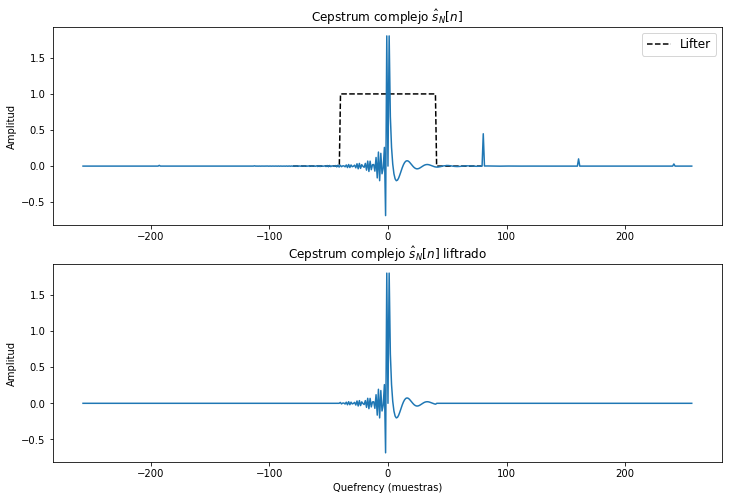

In [16]:
hat_s = hat_h + hat_pn

## Aplico liftrado con quefrency de corte P/2

hat_s_lift = hat_s.copy()
hat_s_lift[41:-40] = 0

win_lift = np.zeros(2*P)
win_lift[:P+1] = signal.windows.boxcar(int(P)+1)
win_lift = np.roll(win_lift, int(P/2))
xlift = np.arange(-int(P),int(P))

plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,1,1)

ax1.plot(xlift, win_lift, '--k', label='Lifter')
ax1.plot(q, np.fft.fftshift(hat_s))
plt.title('Cepstrum complejo $\hat{s}_N[n]$')
plt.ylabel('Amplitud')
plt.legend(fontsize='large')
ax2 = plt.subplot(2,1,2)
ax2.plot(q, np.fft.fftshift(hat_s_lift))
plt.title('Cepstrum complejo $\hat{s}_N[n]$ liftrado')
plt.ylabel('Amplitud')
plt.xlabel('Quefrency (muestras)')
# plt.xlim([xlift[0],xlift[-1]])

# plt.savefig('.\Imagenes\EJ1\hat_s_liftrado.png', dpi=300)

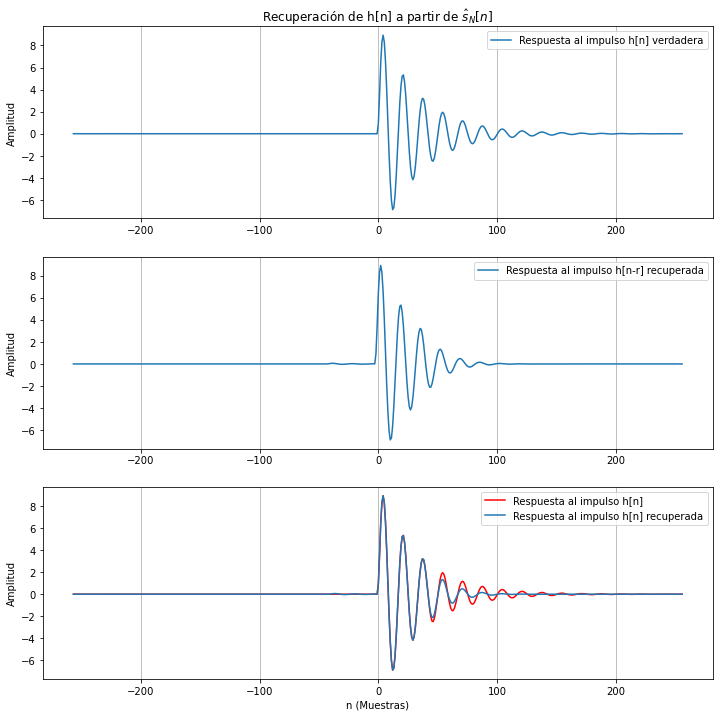

In [17]:
## Calculo de h[n] recuperado

Sn_lift = np.fft.fft(hat_s_lift)
Sn_exp_lift = np.exp(Sn_lift)
hn_rec = np.real(np.fft.ifft(Sn_exp_lift))


### CALCULO DE h[n] verdadera
hn_verdadera = np.real(np.fft.ifft(H))

## Corrección de retraso de una muestra
hn_rec_roll = np.roll(hn_rec,-int(r))


plt.figure(figsize=(12,12))
ax1 = plt.subplot(3,1,1)
ax1.set_title('Recuperación de h[n] a partir de $\hat{s}_N[n]$')
ax1.plot(q, np.fft.fftshift(hn_verdadera), label='Respuesta al impulso h[n] verdadera')
ax1.set_ylabel('Amplitud')
ax1.grid(axis='x')
ax1.legend()
ax2 = plt.subplot(3,1,2)
ax2.plot(q, np.fft.fftshift(hn_rec), label='Respuesta al impulso h[n-r] recuperada')
ax2.set_ylabel('Amplitud')
ax2.grid(axis='x')
ax2.legend()
ax3 = plt.subplot(3,1,3)
ax3.plot(q, np.fft.fftshift(hn_verdadera),'r', label='Respuesta al impulso h[n]')
ax3.plot(q, np.fft.fftshift(hn_rec_roll) ,label='Respuesta al impulso h[n] recuperada')
ax3.grid(axis='x')
ax3.legend()
ax3.set_ylabel('Amplitud')
ax3.set_xlabel('n (Muestras)')

# plt.savefig('.\Imagenes\EJ1\hn_recuperada.png', dpi=300)


##########  PLOTEO PARA OTROS TAMAÑOS DE win_lift
if False:
    plt.figure(figsize=(8,4))
    plt.plot(q, np.fft.fftshift(hn_verdadera),'r', label='Respuesta al impulso h[n]')
    plt.plot(q, np.fft.fftshift(hn_rec_roll) ,label='Respuesta al impulso h[n] recuperada')
    plt.grid(axis='x')
    plt.legend()
    plt.title('h[n] recuperada con liftrado de corte qc=75')
    plt.ylabel('Amplitud')
    plt.xlabel('n (Muestras)')
#     plt.savefig('.\Imagenes\EJ1\hn_anexo2.png', dpi=300)

### Parte 2

In [18]:
###########################################
#
#   Leer archivos
#

# read the audio file to process (from https://openairlib.net/)
filename = './archivos_hoja4/problema1/LP-mem-6-a.wav'

# read audio samples using scipy.io.wavfile
fs, LP_voz = wavread(filename)

referencia = np.loadtxt('./archivos_hoja4/problema1/LP-mem-6-a.txt')
referencia = referencia.T
t_ref = referencia[0]
pitch_ref = referencia[1]

print(f'Frecuencia de muestreo del archivo: {fs}Hz')

Frecuencia de muestreo del archivo: 24000Hz


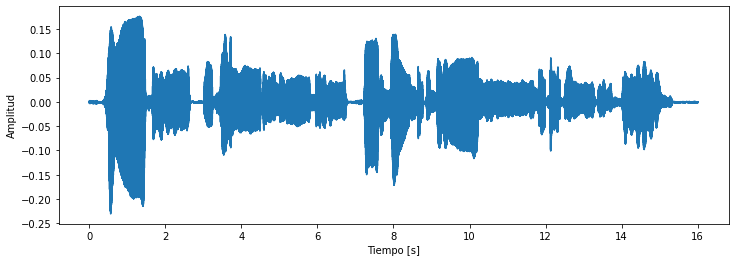

In [19]:
plt.figure(figsize=(12,4))
plot_audio_signal(fs, LP_voz)
ipd.display(ipd.Audio(LP_voz, rate=fs))

In [20]:
def analysis_cepstrum(x, L=960, R=240, win='hann', ind_debug=None):
    """ Calcula los cepstrum reales para una señal x[n]
    
    Parameters
    ----------
    x : numpy array
        input audio signal (mono) as a numpy 1D array.
    L : int
        window length in samples.
    R : int
        hop size in samples.
    win : string
          window type as defined in scipy.signal.windows.    
        
    Returns
    -------
    X_cepst : numpy array
             Cepstrum of x as a numpy 2D array.
    quefr_cepts : numpy array
                 quefrencys values in samples.

    """
    # for time elapsed
    t_ini = time.time()
    
    # length of the input signal
    M = x.size;      
    
    # number of points to compute the DFT (FFT)
    N = 1024
    
    # analysis window
    window = signal.windows.get_window(win, L)
   
    # total number of analysis frames
    num_frames = int(np.floor((M - L) / R))

    # initialize stft
    X_cepst = np.zeros((N, num_frames), dtype = complex)
    
    # process each frame
    for ind in range(num_frames):

        # initial and ending points of the frame
        n_ini = int(ind * R)
        n_end = n_ini + L

        # creo segmento de largo N para computar la DFT
        xr = np.zeros(N)
        
        # signal frame
        señal_env = x[n_ini:n_end] * window
        xr[:L] = señal_env
    
        # logaritmo del modulo
        log_Xr = np.log(np.abs(np.fft.fft(xr, N)))
        
        # save DFT of the signal frame
        X_cepst[:, ind] = np.fft.fftshift(np.real(np.fft.ifft(log_Xr)))
    
        if ind == ind_debug:
            plt.figure(figsize=(12,4))
            plt.plot(np.linspace(-N/2-1, N/2, N), abs(X_cepst[:, ind]))
            
    # frequency values in radians    
    quefr_cepst = np.linspace(-N/2-1, N/2, N)
    
    # time sample at the center of each frame
    samps_cepst = np.arange(num_frames) * R + L/2
    
    print(f'Tiempo de ejecución "analysis_cepstrum": {time.time() - t_ini} s')
    return X_cepst, quefr_cepst, samps_cepst

In [21]:
def cepstrum_lifter(X_cepst_, ind_debug=None, qc=25):
    
    # for time elapsed
    t_ini = time.time()
    
    X_cepst = X_cepst_.copy()
    
    N = X_cepst.shape[0]
    num_frames = X_cepst.shape[1]
        
    # highpass lifter centered in N/2
    lifter = np.ones(N)
    lifter[int(N/2) - int(qc) : int(N/2) + int(qc) + 1] = 0
    
    for ind in np.arange(num_frames):
        
        X_cepst[:,ind] *= lifter
        
        # Debug plot
        if ind == ind_debug:
            plt.figure(figsize=(12,4))
            plt.plot(np.linspace(-N/2-1, N/2, N), abs(X_cepst[:, ind]))
    
    print(f'Tiempo de ejecución "cepstrum_lifter": {time.time() - t_ini} s')
    return X_cepst
    

In [22]:
def cepstrum_pitch_detection(X_cepst, quefrencies, fs, ind_debug=None):
    
    # for time elapsed
    t_ini = time.time()
    
    N = X_cepst.shape[0]
    num_frames = X_cepst.shape[1]
    
    # array for fundamental frequencies
    f_fund = np.zeros(num_frames)
    
    # max frequency index
    if X_cepst.shape[0] % 2 == 0:
        ind_qmax = int(X_cepst.shape[0]/2)
    else:
        ind_qmax = int(X_cepst.shape[0]/2)+1
    
    # keep only positive quefrencies
    X_cepst = np.fft.fftshift(X_cepst, axes=0)[:ind_qmax,:]
    quefrencies = np.fft.fftshift(quefrencies)[:ind_qmax]
    
    for ind in np.arange(num_frames):
        
        umbral = np.max(np.abs(X_cepst[:,ind]))
        picos = signal.find_peaks(np.abs(X_cepst[:,ind]), height=umbral*.6)[0]
        
        if len(picos) <= 3 and (X_cepst[picos[0],ind] > X_cepst[picos[1:],ind]).all():
            f_fund[ind] = fs/quefrencies[picos[0]]
            
        if ind == ind_debug:
            plt.figure(figsize=(12,4))
            plt.plot(quefrencies, np.abs(X_cepst[:,ind]))
            plt.plot(quefrencies[picos], np.abs(X_cepst[picos,ind]),'xr')
            plt.title(f'Cepstrum liftrado para la trama n = {ind}')
            plt.ylabel('Magnitud')
            plt.xlabel('Quefrency')
#             plt.savefig('.\Imagenes\EJ1\deteccion_1_anexo.png', dpi=300)
            print('Frecuencia hallada: ' ,f_fund[ind])
    
    print(f'Tiempo de ejecución "cepstrum_pitch_detection": {time.time() - t_ini} s')
    return f_fund

In [23]:
def cepstrum_pitch_post(pitch_):
    
    # for time elapsed
    t_ini = time.time()
    
    pitch = pitch_.copy()
    for ind in np.arange(pitch.size-1):
        
        # Eliminar picos aislados de una sola muestra
        if pitch[ind-1] == pitch[ind+1] == 0:
            pitch[ind] = 0
        
        # Eliminar picos aislados de más de una muestra
        if pitch[ind] !=0 and (pitch[ind-5:ind] == 0).all() and not (pitch[ind:ind+5] != 0).all():
            pitch[ind] = 0
        
        # Eliminar muestras de pitch = 0 aisladas
        if pitch[ind]==0 and pitch[ind-1] !=0 and pitch[ind+1]!=0:
            pitch[ind] = (pitch[ind-1] + pitch[ind+1])/2
            
        # Eliminar valles aislados de más de una muestra
        if pitch[ind] ==0 and (pitch[ind-5:ind] != 0).all() and not (pitch[ind:ind+5] == 0).all():
            pitch[ind] = pitch[ind-1]
            
        if pitch[ind-1] != 0 and pitch[ind] != 0:
            pitch[ind] = (pitch[ind-1] + pitch[ind])/2
            
    if pitch[-2] == 0:
        pitch[-1] = 0
    
    print(f'Tiempo de ejecución "cepstrum_pitch_post": {time.time() - t_ini} s')
    return pitch

In [24]:
time_ini = time.time()

LP_voz_cepst, quefr_cepst, samps_cepst = analysis_cepstrum(LP_voz)

LP_voz_lift = cepstrum_lifter(LP_voz_cepst)

pitch_cepstrum = cepstrum_pitch_detection(LP_voz_lift, quefr_cepst, fs=fs)

pitch_cepstrum_post = cepstrum_pitch_post(pitch_cepstrum)

print(f'Tiempo transcurrido en el análisis: {time.time() - time_ini} s')

Tiempo de ejecución "analysis_cepstrum": 0.16957807540893555 s
Tiempo de ejecución "cepstrum_lifter": 0.03388071060180664 s
Tiempo de ejecución "cepstrum_pitch_detection": 0.1266944408416748 s
Tiempo de ejecución "cepstrum_pitch_post": 0.013990640640258789 s
Tiempo transcurrido en el análisis: 0.3490924835205078 s


Text(0.5, 0, 'Tiempo [seg]')

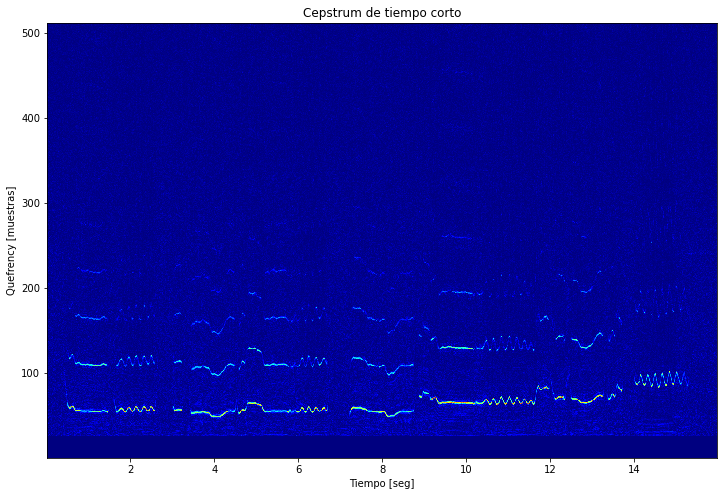

In [25]:
###############################################
#
#  Cepstrum de tiempo corto
#

# time values of the stft
cepst_time = samps_cepst/fs

# max frequency index
if LP_voz_lift.shape[0] % 2 == 0:
    ind_qmax = int(LP_voz_lift.shape[0]/2)
else:
    ind_qmax = int(LP_voz_lift.shape[0]/2)+1

LP_voz_lift_shift = np.fft.fftshift(LP_voz_lift, axes=0)
quefr_cepst_shift = np.fft.fftshift(quefr_cepst)

plt.figure(figsize=(12,8))
plt.pcolormesh(cepst_time, quefr_cepst_shift[:ind_qmax], (np.abs(LP_voz_lift_shift[:ind_qmax, :])), cmap='jet')
# para plotear el log() use el cmap='ocean'

plt.title('Cepstrum de tiempo corto')
plt.ylabel('Quefrency [muestras]')
plt.xlabel('Tiempo [seg]')

# plt.savefig('.\Imagenes\EJ1\Cepstrum_tiempo_corto.png', dpi=600)

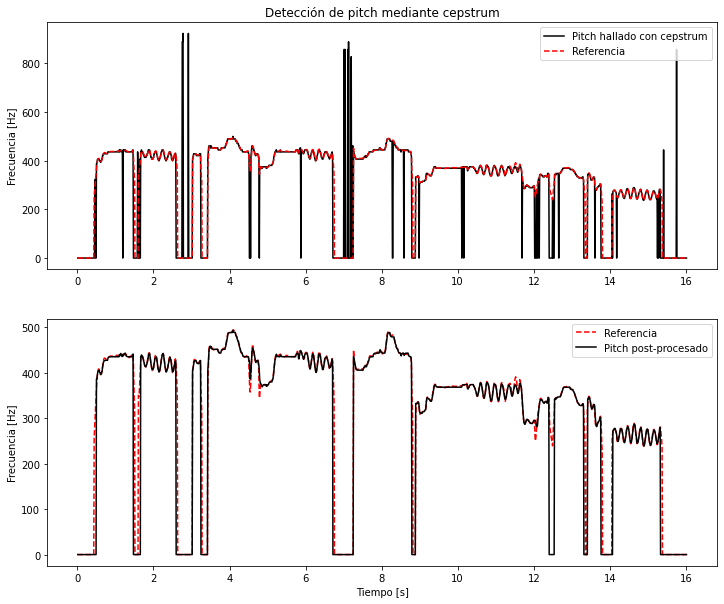

In [26]:
plt.figure(figsize=(12,10))
ax1 = plt.subplot(2,1,1)
ax1.plot(t_ref, pitch_cepstrum, 'k', label='Pitch hallado con cepstrum')
ax1.plot(t_ref, pitch_ref, '--r', label='Referencia')
ax1.set_title('Detección de pitch mediante cepstrum')
ax1.set_ylabel('Frecuencia [Hz]')
ax1.legend()
ax2 = plt.subplot(2,1,2)
ax2.plot(t_ref, pitch_ref, '--r', label='Referencia')
ax2.plot(t_ref, pitch_cepstrum_post, 'k', label='Pitch post-procesado')

ax2.set_ylabel('Frecuencia [Hz]')
ax2.set_xlabel('Tiempo [s]')
ax2.legend()


# plt.savefig('.\Imagenes\EJ1\pitch_detection.png', dpi=300)

Text(0.5, 0, 'Tiempo [s]')

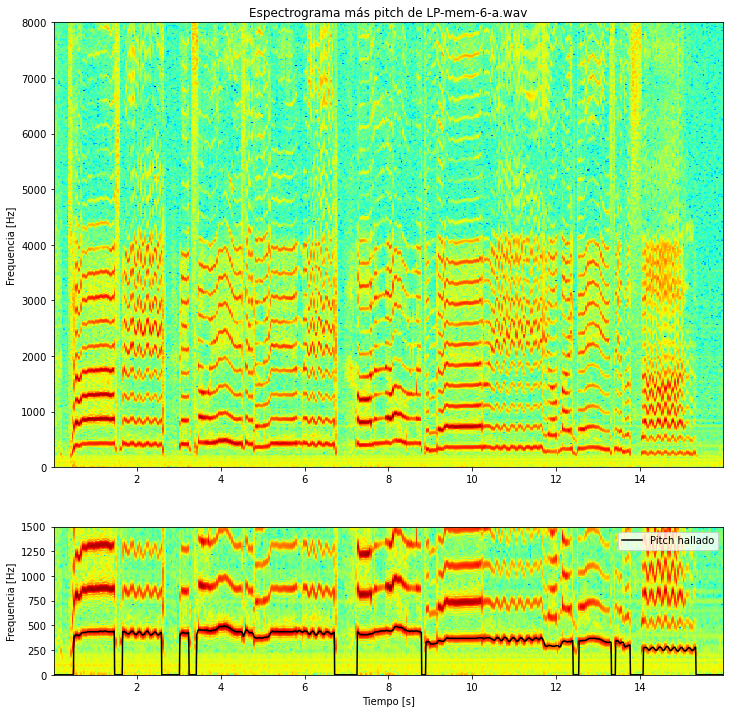

In [27]:
# plt.figure(figsize=(12,8))
# plot_espectrograma(fs, LP_voz, nperseg_=1024, noverlap_=64, nfft_=12000)
# plt.title('Espectrograma de LP-mem-6-a.wav')
# plt.ylim([0,8000])

# plt.savefig('.\Imagenes\EJ1\LP-spectrogram.png', dpi=300)


# plt.figure(figsize=(12,4))

# plot_espectrograma(fs, LP_voz, nperseg_=1024, noverlap_=64, nfft_=12000)
# plt.plot(t_ref[3:-5], pitch_cepstrum_post[3:-5] ,'k', label='Pitch hallado')
# plt.title('Espectrograma más pitch de LP-mem-6-a.wav')
# plt.ylim([0,1500])
# plt.legend()

# plt.savefig('.\Imagenes\EJ1\spect+pitch.png', dpi=300)

nperseg_=1024
noverlap_=64
nfft_=12000

f, t, S = signal.spectrogram(LP_voz, fs, nperseg=nperseg_, noverlap=noverlap_, nfft=nfft_, mode='psd', window='hann')

plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = plt.subplot(gs[0])
ax1.pcolormesh(t, f, 20*np.log10(S), cmap='jet')
ax1.set_title('Espectrograma más pitch de LP-mem-6-a.wav')
ax1.set_ylabel('Frequencia [Hz]')
ax1.set_ylim([0,8000])

ax2 = plt.subplot(gs[1])
ax2.pcolormesh(t, f, 20*np.log10(S), cmap='jet')
ax2.plot(t_ref[3:-5], pitch_cepstrum_post[3:-5] ,'k', label='Pitch hallado')
ax2.set_ylim([0,1500])
ax2.legend()
ax2.set_ylabel('Frequencia [Hz]')
ax2.set_xlabel('Tiempo [s]')

## <center> EJERCICIO 2

In [28]:
## Tabla de fonemas con sus formantes

fonemas_dict = {'a': [800, 1170], 'e': [480, 2300], 'i': [240, 2800], 'o': [510, 960], 'u': [250, 630]}
fonemas_list = ['a', 'e', 'i', 'o', 'u']
fonemas_labels = np.zeros(50)
fonemas_train = np.zeros(25)
fonemas_test = np.zeros(25)

for i in np.arange(5):
    fonemas_labels[i*10:(i+1)*10+1] = int(i)
for i in np.arange(5):
    fonemas_train[i*5:(i+1)*5+1] = int(i)
for i in np.arange(5):
    fonemas_test[i*5:(i+1)*5+1] = int(i)

fonemas_labels_t = np.concatenate([fonemas_labels, fonemas_labels])

## etiquetas

# 'a' = 0
# 'e' = 1
# 'i' = 2
# 'o' = 3
# 'u' = 4

formantes_freq = np.zeros((5,2))
for i, form in zip(np.arange(5), fonemas_dict):
    formantes_freq[i,:] = fonemas_dict[form]

## Importar archivos de audio
fon_martin = []
fon_cecilia = []
train_m = []
train_c = []
test_m = []
test_c = []

fonemas = []
for fonema in fonemas_list:
    for num in np.arange(1,11):
        filename = f'./archivos_hoja4/problema2/vocales/martin/{fonema}-{num}.wav'
        fs, y = wavread(filename)
        fon_martin.append(y)
        fonemas.append(y)
        if num < 6:
            train_m.append(y)
        if num >= 6:
            test_m.append(y)
        
for fonema in fonemas_list:
    for num in np.arange(1,11):
        filename = f'./archivos_hoja4/problema2/vocales/cecilia/{fonema}-{num}.wav'
        fs, y = wavread(filename)
        fon_cecilia.append(y)
        fonemas.append(y)
        if num < 6:
            train_c.append(y)
        if num >= 6:
            test_c.append(y)
        
    
        
fon_martin = np.array(fon_martin)
fon_cecilia = np.array(fon_cecilia)
fonemas = np.array(fonemas)
train_m = np.array(train_m)
train_c = np.array(train_c)
test_m = np.array(test_m)
test_c = np.array(test_c)

print('Cantidad de fonemas hablante masculino: ', fon_martin.size)
print('Cantidad de fonemas hablante femenino: ', fon_cecilia.size)
print('Frecuencia de muestreo: ', fs,'Hz')

Cantidad de fonemas hablante masculino:  50
Cantidad de fonemas hablante femenino:  50
Frecuencia de muestreo:  8000 Hz


In [29]:
def lpc_analysis(s, p=20):
    """ compute the LPC analysis using the autocorrelation method
    
    Parameters
    ----------
    x : numpy array
        windowed signal frame as a numpy 1D array.
    p : int
        model order.
        
    Returns
    -------
    ak : numpy array
         model coefficients.
    e : float
        minimum mean squared error.
    e_norm : float
             normalized minimum mean squared error.
    """
    # frame length
    N = s.shape[0]
    
    # compute autocorrelation values
    r = np.zeros((p+1, 1))
    for k in range(p+1):
        r[k] = np.dot(s[:N-k].T, s[k:])

    # solve to compute model coefficients
    ak = solve(toeplitz(r[:p]), r[1:p+1]).squeeze()

    # compute mean squared error
    e = r[0] - np.dot(ak.T, r[1:p+1])

    # compute normalized mean squared error
    e_norm = e / r[0]

    return ak, e, e_norm


def detectar_formantes(p_, bandwidth_max=200, fs=8000, al=0):
    
    p = p_.copy()
    
    # me quedo con los de fase positiva
    ind_p = np.where(np.angle(p) > 0)[0]
    p = p[ind_p]
    
    # magnitud de los polos
    magp = np.abs(p)
    
    # fase de los polos
    phip = np.angle(p)
    
    # frecuencias de las formantes
    freq_form = phip * fs / (2*np.pi)

    # ancho de banda de las formantes
    bandwidth = (fs/np.pi)*np.log(1/magp)
    
    # indices que cumplen la restriccion
    ind_form = np.where(bandwidth <= bandwidth_max)[0]
    
    # frecuencias de las formantes ordenadas
    formantes = np.sort(freq_form[ind_form])
    formantes = formantes[formantes > 180]
    
    if formantes.size > 2:
        #elegir las primeras 2
        if abs(formantes[0] - formantes[1]) > 250:
            formantes = formantes[:2]
        else:
            # Salteo el formante 2 
            formantes = formantes[:3:2]
    else:
        formantes = formantes[:2]
        
    if formantes.size == 0:
        formantes = np.zeros(2)
    if formantes.size == 1:
        formantes = np.concatenate((formantes, [0]))

    return formantes

In [30]:
def detectar_fonemas(fonemas, fs=fs, p=None, L_=320, debug=False, ind_debug=None, norm='L2', b_max=200):

    # model order
    if p == None:
        p = int(fs/1000) + 4
    
    # points to evaluate
    Ndft = 1024

    etiquetas_ = []
    formantes_ = np.zeros((fonemas.size, 2))

    for ind in np.arange(fonemas.size):
        
        M = fonemas[ind].size
        
        if L_ == 'variable':
            L = int(M/4) * 2
        else:
            L = L_
    
        # hann window of variable size equal to fon.size
        window = signal.windows.get_window('hann', L)

        fonema_win = fonemas[ind][int(M/2)-int(L/2):int(M/2)+int(L/2)] * window

        # apply lpc analysis to signal frame
        ak, e, e_norm = lpc_analysis(fonema_win, p)

        # filter obtained from the lpc analysis
        S = 1
        U = np.concatenate([[1], -ak])

        # compute gain 
        G = np.sqrt(e)

        # compute the frequency response of the digital filter
        w, H = signal.freqz(G*S, U, worN=Ndft, whole=True)
        fw = w / (2 * np.pi) * fs

        # get zero, pole and gain from transfer function
        ceros, polos, k = signal.tf2zpk(G*S, U)
        
        formantes = detectar_formantes(polos, bandwidth_max=b_max, al = ind)
        formantes_[ind,:] = formantes

        distancias = []
        for j in np.arange(len(fonemas_list)):
            if norm == 'L1':
                dist = np.sum(np.abs(formantes_freq[j,:] - formantes))
            if norm == 'L1log':
                dist = np.sum(np.abs(np.log(formantes_freq[j,:]) - np.log(formantes)))
            if norm == 'L2':
                dist = np.sqrt(np.sum(np.abs(formantes_freq[j,:] - formantes)**2))
            if norm == 'L2log':
                dist = np.sqrt(np.sum(np.abs(np.log(formantes_freq[j,:]) - np.log(formantes))**2))
            distancias.append(dist)
        
        etiqueta = np.argmin(distancias)
        etiquetas_.append(etiqueta)
        
        ####################################################
        ##              PLOTEO PARA DEBUG
        if debug and ind==ind_debug:
            print(f'Formantes: {formantes[0]:.2f} Hz - {formantes[1]:.2f} Hz')
            print(f'Fonema hallado: {fonemas_list[etiqueta]}')
            print(f'Formantes cercanas: {formantes_freq[etiqueta,:]}')
            print('')
            # spectrum of the signal frame
            X = np.fft.fft(fonema_win, Ndft)
            # frequency values
            f = np.fft.fftfreq(Ndft) * fs
            # magnitude spectrum
            magX = np.abs(X)
            ind_fmx = int(Ndft/2)
            
            # magnitude spectrum
            magH = np.abs(H)
            ind_fmx = int(Ndft/2)

            # plot the frequency response
            plt.figure(figsize=(12,6))
            plt.title(f'Espectro de fonema y respuesta en frecuencia del LPC - fonema "{fonemas_list[ind_debug//10]}"')
            plt.plot(f[:ind_fmx], 20 * np.log10(magX[:ind_fmx]), 'k')
            plt.plot(f[:ind_fmx], 20 * np.log10(magH[:ind_fmx]), 'r')
            plt.text(3500,25,f'$F_1$ hallada - {formantes[0]:.2f}Hz \n$F_2$ hallada - {formantes[1]:.2f}Hz', bbox=dict(facecolor='black', alpha=0.1))
            plt.ylabel('Magnitud (dB)')
            plt.xlabel('Frequencia (Hz)')
            plt.tight_layout()
            # plt.savefig('.\Imagenes\EJ2\LPC_eror_M_2.png', dpi=300)
            
            # Diagrama de polos y ceros
            # plot zero pole diagram
            plt.figure(figsize=(12, 12))
            ax1 = plt.subplot(2, 1, 1)
            ax = plt.subplot(2, 2, 1)
            # unit circle and zero axes    
            unit_circle = patches.Circle((0,0), radius=1, fill=False,
                                         color='black', ls='solid', alpha=0.6)
            ax.add_patch(unit_circle)
            axvline(0, color='0.6')
            axhline(0, color='0.6')

            # plot the zeros and set marker properties    
            t1 = plt.plot(ceros.real, ceros.imag, 'go', ms=10)
            plt.setp(t1, markersize=10.0, markeredgewidth=1.0,
                     markeredgecolor='k', markerfacecolor='g')
            # plot the poles and set marker properties
            t2 = plt.plot(polos.real, polos.imag, 'rx', ms=10)
            plt.setp(t2, markersize=12.0, markeredgewidth=3.0,
                     markeredgecolor='r', markerfacecolor='r')

            plt.title("Pole-Zero Plot")
            plt.xlabel("Real")
            plt.ylabel("Imaginary");
            # plt.savefig('.\Imagenes\EJ2\zpk_eror_M_2.png', dpi=300)
        #######################################################
        
    return etiquetas_ , formantes_

In [31]:
norma = 'L2'
BW = 200

etiquetas_todos, formantes_todos = detectar_fonemas(fonemas, fs=fs, b_max=BW, norm=norma)
etiquetas_martin, formantes_martin = detectar_fonemas(fon_martin, fs=fs, b_max=BW, norm=norma)
etiquetas_cecilia, formantes_cecilia = detectar_fonemas(fon_cecilia, fs=fs, b_max=BW, norm=norma)

In [32]:
aciertos_m = np.sum(fonemas_labels == etiquetas_martin)
accuracy_m = aciertos_m / fonemas_labels.size
tasa_acc_m = np.zeros(5)
tasa_acc_c = np.zeros(5)

# Tasa para todos juntos
accuracy_todos = np.sum(etiquetas_todos == fonemas_labels_t)/100
print('Aciertos totales: ', accuracy_todos)
print('-'*20)

for i in np.arange(5):
    tasa_acc_m[i] = np.sum(fonemas_labels[i*10:(i+1)*10] == etiquetas_martin[i*10:(i+1)*10])/10
    tasa_acc_c[i] = np.sum(fonemas_labels[i*10:(i+1)*10] == etiquetas_cecilia[i*10:(i+1)*10])/10
    
print(f'Aciertos Martin: {aciertos_m}/50')
print('Tasa de acierto total: ', accuracy_m)
for i in np.arange(5):
    print(f'Tasa de acierto fonema "{fonemas_list[i]}": {tasa_acc_m[i]}')
print('-'*20)
aciertos_c = np.sum(fonemas_labels == etiquetas_cecilia)
accuracy_c = aciertos_c / fonemas_labels.size
print(f'Aciertos Cecilia: {aciertos_c}/50')
print('Tasa de acierto total: ', accuracy_c)
for i in np.arange(5):
    print(f'Tasa de acierto fonema "{fonemas_list[i]}": {tasa_acc_c[i]}')


Aciertos totales:  0.73
--------------------
Aciertos Martin: 36/50
Tasa de acierto total:  0.72
Tasa de acierto fonema "a": 0.9
Tasa de acierto fonema "e": 0.9
Tasa de acierto fonema "i": 0.2
Tasa de acierto fonema "o": 0.6
Tasa de acierto fonema "u": 1.0
--------------------
Aciertos Cecilia: 37/50
Tasa de acierto total:  0.74
Tasa de acierto fonema "a": 0.8
Tasa de acierto fonema "e": 0.8
Tasa de acierto fonema "i": 0.7
Tasa de acierto fonema "o": 0.6
Tasa de acierto fonema "u": 0.8


Text(0, 0.5, 'Formante 2 [Hz]')

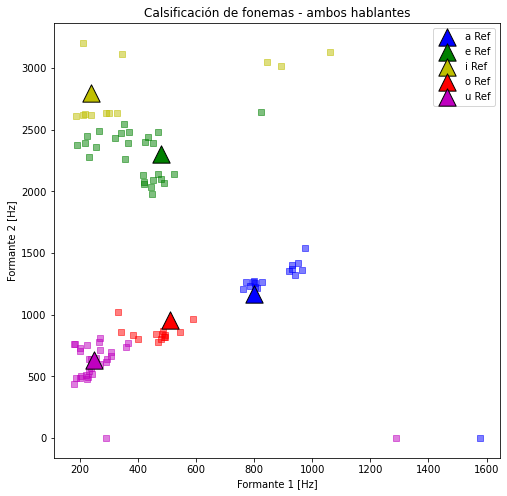

In [33]:
markers = ['b^', 'g^', 'y^', 'r^', 'm^']
colors = ['b', 'g', 'y', 'r', 'm']

colors_martin = [colors[etiqueta] for etiqueta in etiquetas_martin]
colors_cecilia = [colors[etiqueta] for etiqueta in etiquetas_cecilia]
colors_todos = [colors[etiqueta] for etiqueta in etiquetas_todos]

plt.figure(figsize=(8,8))
for i in np.arange(100):
    plt.scatter(formantes_todos[i, 0], formantes_todos[i,1],c=colors_todos[i], marker= "s", alpha=0.5)
for i in np.arange(5):
    plt.scatter(formantes_freq[i,0], formantes_freq[i,1], marker='^', c=colors[i],
                label=fonemas_list[i]+' Ref', s=300, edgecolors='black')
plt.legend()
plt.title('Calsificación de fonemas - ambos hablantes')
plt.xlabel('Formante 1 [Hz]')
plt.ylabel('Formante 2 [Hz]')

# plt.savefig('.\Imagenes\EJ2\mapa_formantes_todos.png', dpi=300)

### Análisis por separado





Clasificador para cada hablante

In [34]:
#### PSEUDO VALIDACION
norma = 'L2log'

acc_m_train = []
acc_c_train = []
acc_m_test = []
acc_c_test = []
polos = np.arange(4,20)
anchos = np.arange(170, 245, 5)

for ancho in anchos:
    for p_ in polos:
        etiquetas_martin_train = detectar_fonemas(train_m, p=p_, b_max=ancho, norm=norma)[0]
        etiquetas_cecilia_train = detectar_fonemas(train_c, p=p_, b_max=ancho, norm=norma)[0]
        aciertos_m = np.sum(fonemas_train == etiquetas_martin_train)
        acc_m_train.append(aciertos_m / fonemas_train.size)
        aciertos_c = np.sum(fonemas_train == etiquetas_cecilia_train)
        acc_c_train.append(aciertos_c / fonemas_train.size)
        
        etiquetas_martin_test = detectar_fonemas(test_m, p=p_, b_max=ancho, norm=norma)[0]
        etiquetas_cecilia_test = detectar_fonemas(test_c, p=p_, b_max=ancho, norm=norma)[0]
        aciertos_m = np.sum(fonemas_test == etiquetas_martin_test)
        acc_m_test.append(aciertos_m / fonemas_test.size)
        aciertos_c = np.sum(fonemas_test == etiquetas_cecilia_test)
        acc_c_test.append(aciertos_c / fonemas_test.size)
        

c:\users\santiago\audio_env\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


In [35]:
Ein_m = 1 - np.array(acc_m_train)
Ein_m = 1 - np.array(acc_m_train)
Eout_m  = 1 - np.array(acc_m_test)
Eout_c  = 1 - np.array(acc_c_test)

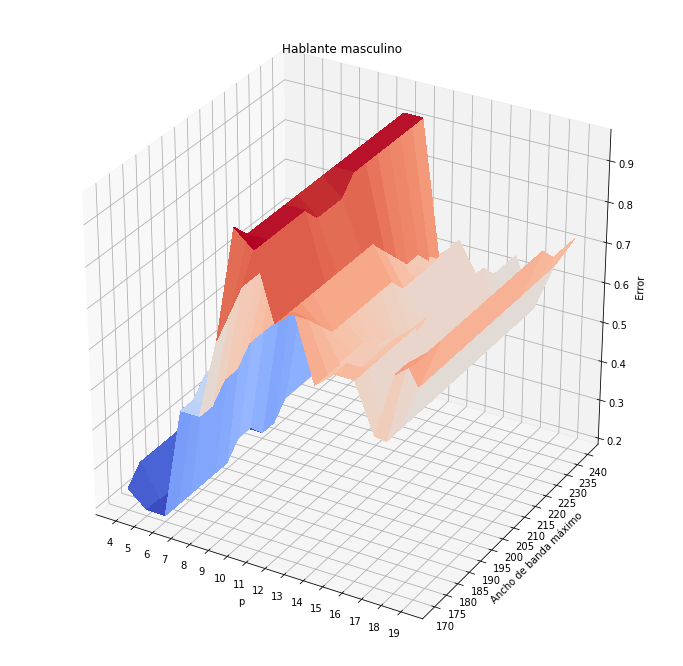

In [36]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

XX = polos
YY = anchos
XX, YY = np.meshgrid(XX, YY)
ZZ = np.reshape(acc_m_test, (len(anchos), len(polos)))
ZZ_2 = np.reshape(acc_m_test, (len(anchos), len(polos)))

surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# surf_Eout = ax.plot_surface(XX, YY, ZZ_2,
#                        linewidth=0, antialiased=False)

plt.title('Hablante masculino')
ax.set_xlabel('p')
ax.set_ylabel('Ancho de banda máximo')
ax.set_zlabel('Error')
ax.set_xticks(polos);
ax.set_yticks(anchos);

# ax.view_init(30, 180)
# plt.draw()
# plt.pause(.001)
# plt.savefig('.\Imagenes\EJ2\iteracion_M_3D_error.png', dpi=300 )

if False:
    plt.figure(figsize=(8,8))
    plt.plot(anchos, ZZ[:,8])
    plt.xticks(anchos);
    plt.title('Hablante masculino - p=10')
    plt.ylabel('Error')
    plt.xlabel('Ancho de banda máximo')
    # plt.savefig('.\Imagenes\EJ2\Error_M_ancho.png', dpi=300)

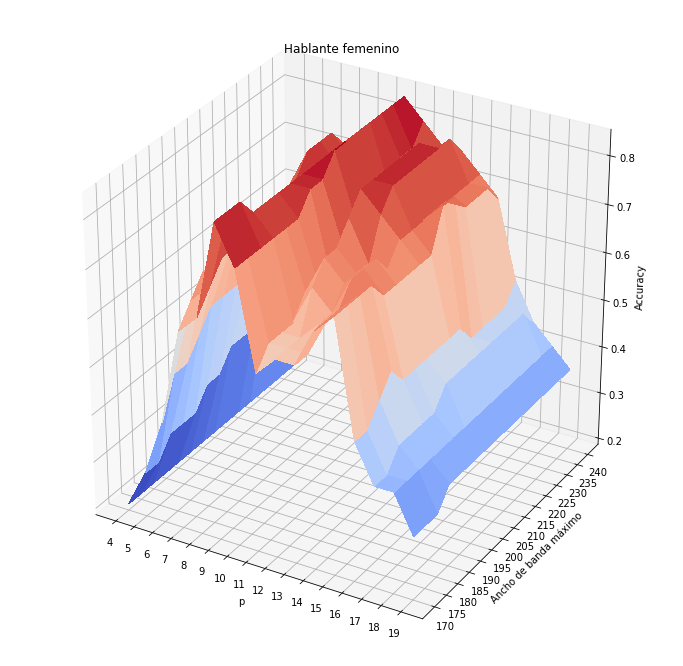

In [37]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

XX = polos
YY = anchos
XX, YY = np.meshgrid(XX, YY)
ZZ = np.reshape(acc_c_test, (len(anchos), len(polos)))

surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title('Hablante femenino')
ax.set_xlabel('p')
ax.set_ylabel('Ancho de banda máximo')
ax.set_zlabel('Accuracy')
ax.set_xticks(polos);
ax.set_yticks(anchos);
# plt.savefig('.\Imagenes\EJ2\iteracion_C_3D.png', dpi=300 )

if False:
    plt.figure(figsize=(8,8))
    plt.plot(anchos, ZZ[:,7])
    plt.xticks(anchos);
    plt.title('Hablante femenino - p=9')
    plt.ylabel('Accuracy')
    plt.xlabel('Ancho de banda máximo')
    # plt.savefig('.\Imagenes\EJ2\Accuracy_C_ancho.png', dpi=300)

In [38]:
# ANALISIS POR SEPARADO
etiquetas_martin, formantes_martin = detectar_fonemas(fon_martin, p=10, L_='variable', b_max=170, debug=False, ind_debug=20, norm='L2log')
etiquetas_cecilia, formantes_cecilia = detectar_fonemas(fon_cecilia, p=9, L_='variable', b_max=220, debug=False, ind_debug=2, norm='L2log')

c:\users\santiago\audio_env\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


In [39]:
tasa_acc_m = np.zeros(5)
tasa_acc_c = np.zeros(5)

for i in np.arange(5):
    tasa_acc_m[i] = np.sum(fonemas_labels[i*10:(i+1)*10] == etiquetas_martin[i*10:(i+1)*10])/10
    tasa_acc_c[i] = np.sum(fonemas_labels[i*10:(i+1)*10] == etiquetas_cecilia[i*10:(i+1)*10])/10
    
# MARTIN
aciertos_m = np.sum(fonemas_labels == etiquetas_martin)
accuracy_m = aciertos_m / fonemas_labels.size   
print(f'Aciertos Martin: {aciertos_m}/50')
print('Tasa de acierto total: ', accuracy_m)
for i in np.arange(5):
    print(f'Tasa de acierto fonema "{fonemas_list[i]}": {tasa_acc_m[i]}')
print('-'*20)

# CECILIA
aciertos_c = np.sum(fonemas_labels == etiquetas_cecilia)
accuracy_c = aciertos_c / fonemas_labels.size
print(f'Aciertos Cecilia: {aciertos_c}/50')
print('Tasa de acierto total: ', accuracy_c)
for i in np.arange(5):
    print(f'Tasa de acierto fonema "{fonemas_list[i]}": {tasa_acc_c[i]}')


Aciertos Martin: 49/50
Tasa de acierto total:  0.98
Tasa de acierto fonema "a": 1.0
Tasa de acierto fonema "e": 1.0
Tasa de acierto fonema "i": 0.9
Tasa de acierto fonema "o": 1.0
Tasa de acierto fonema "u": 1.0
--------------------
Aciertos Cecilia: 42/50
Tasa de acierto total:  0.84
Tasa de acierto fonema "a": 0.9
Tasa de acierto fonema "e": 0.9
Tasa de acierto fonema "i": 0.6
Tasa de acierto fonema "o": 0.9
Tasa de acierto fonema "u": 0.9


In [40]:
if False:
    for ind, etiqueta in zip(np.arange(50),etiquetas_cecilia):
        print(ind,' ',fonemas_list[etiqueta])
        print(ind, formantes_cecilia[ind])

In [41]:
if False:
    for ind, etiqueta in zip(np.arange(50),etiquetas_martin):
        print(ind,' ',fonemas_list[etiqueta])
        print(ind, formantes_martin[ind])

Text(0, 0.5, 'Formante 2 [Hz]')

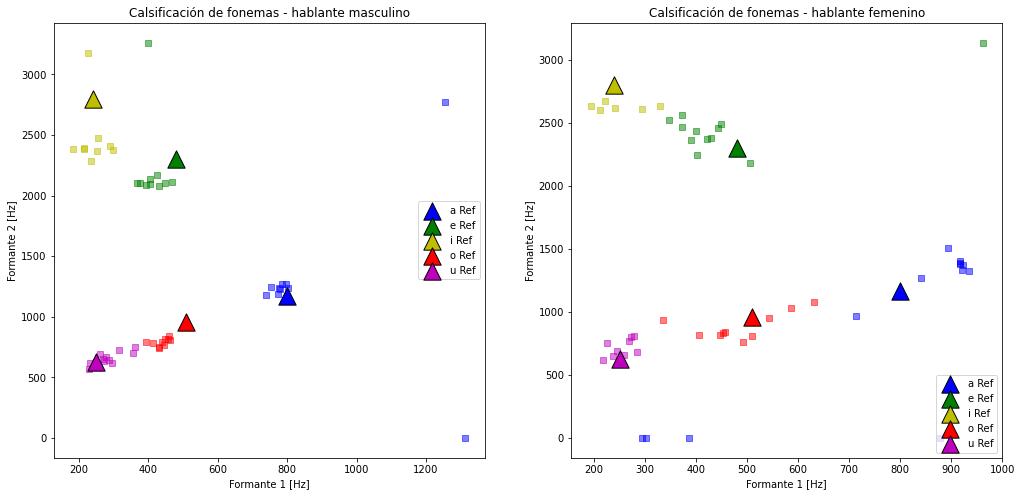

In [42]:
markers = ['b^', 'g^', 'y^', 'r^', 'm^']
colors = ['b', 'g', 'y', 'r', 'm']

colors_martin = [colors[etiqueta] for etiqueta in etiquetas_martin]
colors_cecilia = [colors[etiqueta] for etiqueta in etiquetas_cecilia]

plt.figure(figsize=(17,8))
ax1 = plt.subplot(1,2,1)
for i in np.arange(50):
    ax1.scatter(formantes_martin[i, 0], formantes_martin[i,1],c=colors_martin[i], marker= "s", alpha=0.5)
for i in np.arange(5):
    ax1.scatter(formantes_freq[i,0], formantes_freq[i,1], marker='^', c=colors[i],
                label=fonemas_list[i]+' Ref', s=300, edgecolors='black')
plt.legend(loc='center right')
plt.title('Calsificación de fonemas - hablante masculino')
plt.xlabel('Formante 1 [Hz]')
plt.ylabel('Formante 2 [Hz]')

ax2 = plt.subplot(1,2,2)
for i in np.arange(50):
    ax2.scatter(formantes_cecilia[i, 0], formantes_cecilia[i,1],c=colors_cecilia[i], marker= "s", alpha=0.5)
for i in np.arange(5):
    ax2.scatter(formantes_freq[i,0], formantes_freq[i,1], marker='^', c=colors[i],
             label=fonemas_list[i]+' Ref', s=300, edgecolors='black')
plt.legend(loc='lower right')
plt.title('Calsificación de fonemas - hablante femenino')
plt.xlabel('Formante 1 [Hz]')
plt.ylabel('Formante 2 [Hz]')

# plt.savefig('.\Imagenes\EJ2\mapa_formantes_L2log.png', dpi=300)